# [Analysing Expected Goals (xG) in Football](#expected-goals)

## [What is xG?](#xg)

Every football match consists of players who attempt to score goals by shooting the ball at the goal. One question that arises in one's mind is, 

> <div class="alert alert-block alert-info">
    <b> What is the probability that the shot will end up in the back of the net?</b> 
</div>

A countless number of factors that include the distance from the goal, if it was shot with a weak foot, the number of players between the player and the goal, the angle of the shot, the build up play to the goal and more can determine this. This probability metric is called Expected Goals metric.

The Expected Goals metric plays a crucial role in player profiling, transfer market trends and team strategies. 
 

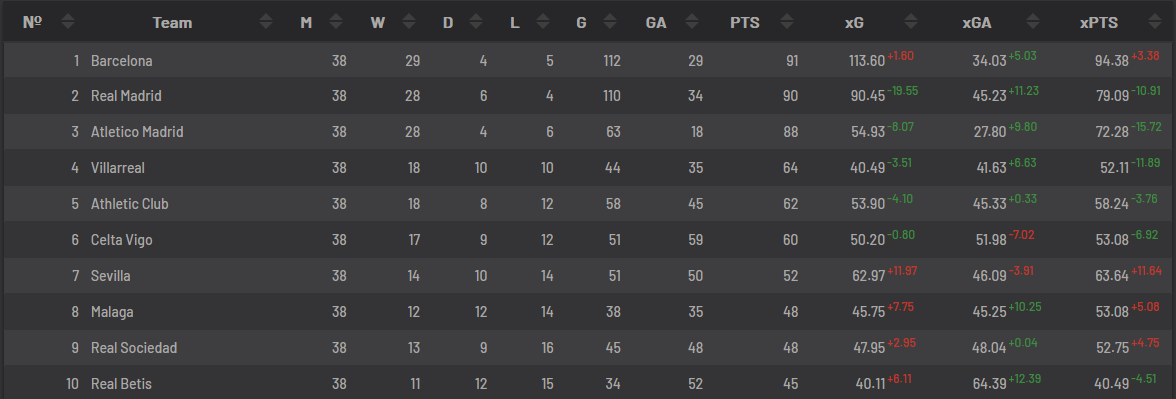

## [Aims and Objectives](#aims-and-objectives)

The aim of this notebook, is to explore the open data provided by __[Statsbomb](http://statsbomb.com)__ to create a model based on Machine Learning to calculate and predict the Expected Goals in football matches. The data that will be used is based on the Barclays FA Women's Super League which is the highest level of football competition for women in England, 2018 Fifa Women's World Cup and the National Women's Soccer League, which is the highest level of football competition for women in the United States.

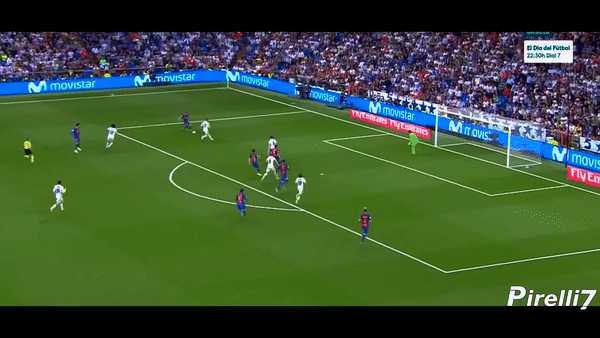

# [Understanding the Data and building the Data Pipeline](#data-pipeline)

A data pipeline includes the following steps:
1. Data Extraction 
2. Data Wrangling
3. Exploratory Data Analysis
4. Data Visualisation

In the cells below I will be explaining each step as I extract the data and perform different processes to shape it for the purposes of the project. 

#### Importing the libraries that will be needed

In [366]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc
%matplotlib inline

# [The Specifications of the Dataset](#dataset)

The following data is available in the dataset:
1. Competition Data
2. Match Data
3. Lineup Data
4. Event Data

I will be using the event data for most of the project, since it contains valuable information about the location from where the ball was shot from, technique used, statsbomb's xG prediction and many other features.

#### Importing the data 

I will proceed to import the matches from the competitions that we will be analysing. The competition IDs for the three competitions are:

1. 37
2. 49
3. 72

We will be accessing the data using these three IDs.

Since there are 3 json files that include the matches from the three competitions described in the [Aims and Objectives](#aims-and-objectives), a list of the competitions ids is created. Each element is the name of the json file containing matches from that competition. The list of competitions contains the path to each json file.

In [70]:
#Creating the list of competitions containing a pathway to each competition directory
data_matches = "C:\\Users\\Ayush Maria\\Desktop\\Thesis\\open-data-master\\data\\matches"
competition_id = ["37","49","72"]
list_of_competitions = []
for i in competition_id:
    path = data_matches + "\\" + i
    list_of_competitions.extend(glob.glob(path + "\\*.json"))

Now that we have the path to the matches in each of the competition, we will extract match data and engineer it for the purpose of the project. The list 

In [71]:
#creating a dictionary with match id as the key and the home team name for its respective value
match_id = []
home_team_names = []
id_vs_home_dict = {}

for competition in list_of_competitions:
    df_competitions = pd.read_json(competition)
    match_id.extend(df_competitions['match_id'].values)
    for i in range(0,df_competitions.shape[0]):
        home_team_names.append(df_competitions['home_team'].values[i]['home_team_name'])

id_vs_home_list = list(zip(match_id,home_team_names))
id_vs_home_dict = {match:home for match,home in id_vs_home_list}

In [72]:
#creating a list for each of the events provided in the data set that is procured from Statsbomb
data_events = "C:\\Users\\Ayush Maria\\Desktop\\Thesis\\open-data-master\\data\\events\\"
list_of_shots = []                         #list of shots
list_of_locations = []                     #location of the shot
timestamp_of_shot = []                     #time of the shot
technique_of_shot = []                     #technique used in the shot
id_of_technique = []                       #id of the technique used 
name_of_bodypart = []                      #body part where the shot was taken from
id_of_bodypart = []                        #ids of the body part 
name_of_play_pattern = []                  #play pattern names
id_of_play_pattern = []                    #play pattern ids
first_touch_shot = []                      #whether shot was taken first time 
xG_prediction_statsbomb = []               #statsbomb's xG prediction
type_of_key_pass = []                      #the assist leading up to the shot
pattern_of_key_pass = []                   #type of assist event
cross_or_not = []                          #if a cross was a assist 
cutback_or_not = []                        #if a cutback pass was a assist
name_of_player = []                        #the player who took the shot
home_vs_away = []                          #the team the player belongs to
preceding_event_list = []                  #the event preceding the shot
preceding_event_player_list = []           #the player involved in preceding event
preceding_event_team_list = []             #the team of the player involved
outcome_of_shot = []                       #outcome of the shot
id_of_outcome = []                         #all shot outcome ids as per data
shot_freeze_frames = []                    #freeze frame of the location of the shot

In [73]:
#extracting the above information
for match in match_id:
    matchname = str(match)
    path = data_events + matchname + ".json"
    df_events = pd.read_json(path)
    df_shots = df_events[['index','timestamp','shot','location','player','possession_team']].dropna()
    list_of_shots.append(df_shots.dropna().shape[0])
    list_of_locations.extend(list(df_shots['location'].values))
    timestamp_of_shot.extend(list(df_shots['timestamp'].values))
    
    for i in range(0,len(df_shots)):
        outcome_of_shot.append(df_shots.iloc[i][2]['outcome']['name'])
        id_of_outcome.append(df_shots.iloc[i][2]['outcome']['id'])
        name_of_bodypart.append(df_shots.iloc[i][2]['body_part']['name'])
        id_of_bodypart.append(df_shots.iloc[i][2]['body_part']['id'])
        technique_of_shot.append(df_shots.iloc[i][2]['technique']['name'])
        id_of_technique.append(df_shots.iloc[i][2]['technique']['id'])
        name_of_play_pattern.append(df_shots.iloc[i][2]['type']['name'])
        id_of_play_pattern.append(df_shots.iloc[i][2]['type']['id'])
        name_of_player.append(df_shots.iloc[i][4]['name'])
        
        if df_shots.iloc[i][5]['name'] == id_vs_home_dict[match]:
            home_vs_away.append('home')
        else:
            home_vs_away.append('away')
                    #team_list.append(df_shots.iloc[i][5]['name'])
        
        #Whether a shot was a first time shot is indicated by a Boolean. Many shots are not first time shots
        #Error handling is used to not stop data extraction
        try:
            first_touch_shot.append(df_shots.iloc[i][2]['first_time'])
        except:
            first_touch_shot.append(False)
        
        #Many shots do not have a preceding key pass. Error handling is used in such cases
        try:
            key_pass = df_shots.iloc[i][2]['key_pass_id']
            filt1 = df_events['id']==key_pass
            pass_info = df_events[filt1].dropna(axis='columns')['pass']
            type_of_key_pass.append(pass_info.iloc[0]['height']['name'])
            pattern_info = df_events[filt1].dropna(axis='columns')['play_pattern']
            pattern_of_key_pass.append(pattern_info.iloc[0]['name'])
            try:
                if pass_info.iloc[0]['cross']==True:
                    cross_or_not.append(True)
                else:
                    cross_list.append(False)
            except KeyError:
                cross_or_not.append(False)
            try:
                if pass_info.iloc[0]['cut_back']==True:
                    cutback_or_not.append(True)
                else:
                    cutback_or_not.append(False)
            except KeyError:
                cutback_or_not.append(False)
                
        except KeyError:
            type_of_key_pass.append(np.nan)
            cutback_or_not.append(False)
            cross_or_not.append(False)
            pattern_of_key_pass.append(np.nan)
            
        #Extracting the event preceding the shot
        idx_filt = df_shots.iloc[i,0]-1
        filt = df_events['index']==idx_filt
        df_events_filt=df_events[filt].dropna(axis='columns')
        preceding_event_list.append(df_events_filt['type'].values[0]['name'])
        try:
            preceding_event_player_list.append(df_events_filt['player'].values[0]['name'])
        except:
            preceding_event_player_list.append(np.nan)
        preceding_event_team_list.append(df_events_filt['possession_team'].values[0]['name'])
        
        #extracting statsbomb xG
        xG_prediction_statsbomb.append(df_shots.iloc[i][2]['statsbomb_xg'])

In [74]:
def vectorize(pointa, pointb):
    '''
    Given two points, create a vector from the first to the second
    
    Arguments:
        pointa, pointb - x,y co-ordinates (list)
    
    Returns:
        vector from point a to point b
    '''
    return [pointb[0]-pointa[0], pointb[1]-pointa[1]]


def isInside(point_shot, point_goal1, point_goal2, point_freeze):
    '''
    Given the three vertices of a triangle, this function determines if a fourth
    point lies inside the triangle
    
    Arguments:
        point_shot - shot location x,y (list)
        point_goal1 and point_goal2 - goal edges x,y (list)
        point_freeze - player location x,y(list)
        
    Returns:
        True or False (boolean)
    
    '''
    v2 = vectorize(point_freeze, point_shot)
    v0 = vectorize(point_goal1, point_shot)
    v1 = vectorize(point_goal2, point_shot)

    u = (np.dot(v1, v1)*np.dot(v2, v0)-np.dot(v1, v0)*np.dot(v2, v1)) / \
        (np.dot(v0, v0)*np.dot(v1, v1)-np.dot(v0, v1)*np.dot(v1, v0))
    v = (np.dot(v0, v0)*np.dot(v2, v1)-np.dot(v0, v1)*np.dot(v2, v0)) / \
        (np.dot(v0, v0)*np.dot(v1, v1)-np.dot(v0, v1)*np.dot(v1, v0))

    if u < 0 or v < 0:
        return False
    elif u > 1 or v > 1:
        return False
    elif u+v > 1:
        return False
    else:
        return True

In [75]:
#defining edges of goal
goal_x1y1 = [120,36]
goal_x2y2 = [120,44]
pack_density_list = [] 

In [76]:
for match in match_id:
    matchname = str(match)
    path = data_events + matchname + ".json"
    df_events = pd.read_json(path)
    df_shots = df_events[['index','timestamp','shot','location','player','possession_team']].dropna()
    
    for i in range(0,len(df_shots)):
        shot_loc=df_shots['location'].iloc[i]
        shot_freeze_frames=[]
        # in cases of penalties, a freeze frame is not provided so a KeyError will be raised
        # using error handling to append 1 in such cases
        try:
            for j in range(0,len(df_shots['shot'].iloc[i]['freeze_frame'])):
                location=df_shots['shot'].iloc[i]['freeze_frame'][j]['location']
                shot_freeze_frames.append(isInside(shot_loc,goal_x1y1,goal_x2y2,location))
        except KeyError:
            shot_freeze_frames.append(1) 
        pack_density_list.append(sum(shot_freeze_frames))

C:\Users\Ayush Maria\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Ayush Maria\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Ayush Maria\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Ayush Maria\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


In [77]:
pack_density_list

[1,
 4,
 5,
 2,
 3,
 2,
 1,
 4,
 2,
 1,
 5,
 2,
 1,
 2,
 1,
 2,
 3,
 1,
 1,
 2,
 1,
 0,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 4,
 2,
 6,
 0,
 0,
 1,
 1,
 1,
 4,
 2,
 3,
 7,
 2,
 1,
 1,
 1,
 2,
 1,
 4,
 3,
 2,
 2,
 4,
 2,
 2,
 4,
 2,
 2,
 1,
 5,
 4,
 1,
 3,
 1,
 3,
 1,
 2,
 1,
 3,
 3,
 2,
 2,
 2,
 2,
 1,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 3,
 2,
 4,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 4,
 2,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 2,
 6,
 1,
 2,
 1,
 1,
 1,
 3,
 3,
 1,
 4,
 3,
 4,
 2,
 1,
 4,
 2,
 1,
 2,
 1,
 0,
 5,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 4,
 2,
 3,
 2,
 2,
 1,
 5,
 1,
 1,
 2,
 2,
 1,
 5,
 1,
 4,
 2,
 3,
 4,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 1,
 2,
 1,
 0,
 4,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 5,
 4,
 5,
 2,
 2,
 3,
 1,
 2,
 2,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 4,
 1,
 0,
 1,
 1,
 1,
 4,
 5,
 2,
 1,


In [78]:
df = pd.DataFrame(list_of_locations)

In [79]:
df.columns = ['shot_x','shot_y']
df['shot_distance'] = round(np.sqrt((df['shot_x']-120)**2+(df['shot_y']-40)**2),1)
df['shot_a'] = np.sqrt((df['shot_x']-120)**2+(df['shot_y']-36)**2)
df['shot_b'] = np.sqrt((df['shot_x']-120)**2+(df['shot_y']-44)**2)
#calculating angle using cosine rule
df['shot_angle'] = np.arccos((df['shot_a']**2+df['shot_b']**2-64)/(2*df['shot_a']*df['shot_b']))
df['shot_angle'] = np.degrees(df['shot_angle'])
df['shot_angle'] = round(df['shot_angle'],1)

C:\Users\Ayush Maria\AppData\Roaming\Python\Python37\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [80]:
df['timestamp'] = timestamp_of_shot
df['outcome_name'] = outcome_of_shot
df['outcome_id'] = id_of_outcome
df['body_part_name'] = name_of_bodypart
df['body_part_id'] = id_of_bodypart
df['technique_name'] = technique_of_shot
df['technique_id'] = technique_id_list
df['type_name'] = name_of_play_pattern
df['type_id'] = id_of_play_pattern
df['first_time'] = first_touch_shot
df['preceding_event'] = preceding_event_list
df['pack_density'] = pack_density_list
df['shot_player'] = player_list
df['home_or_away'] = home_vs_away
df['key_pass_type'] = type_of_key_pass
df['key_pass_pattern'] = pattern_of_key_pass
df['isCross'] = cross_or_not
df['isCutback'] = cutback_or_not
df['preceding_event'] = preceding_event_list
df['preceding_event_player'] = preceding_event_player_list
df['preceding_event_team'] = preceding_event_team_list
df['statsbomb_xg'] = xG_prediction_statsbomb

In [81]:
df.isna().sum()

shot_x                       0
shot_y                       0
shot_distance                0
shot_a                       0
shot_b                       0
shot_angle                   2
timestamp                    0
outcome_name                 0
outcome_id                   0
body_part_name               0
body_part_id                 0
technique_name               0
technique_id                 0
type_name                    0
type_id                      0
first_time                   0
preceding_event              0
pack_density                 0
shot_player                  0
home_or_away                 0
key_pass_type             3376
key_pass_pattern          3376
isCross                      0
isCutback                    0
preceding_event_player      13
preceding_event_team         0
statsbomb_xg                 0
dtype: int64

In [82]:
#analyzing missing shot_angle
missing_shot_angle = df['shot_angle'].isna()
df[missing_shot_angle]

shot_x  shot_y  shot_distance  shot_a  shot_b  shot_angle  \
3914   120.0    30.6            9.4     5.4    13.4         NaN   
5538   120.0    34.7            5.3     1.3     9.3         NaN   

                   timestamp outcome_name  outcome_id body_part_name  ...  \
3914 2022-05-26 00:00:19.337        Saved         100     Right Foot  ...   
5538 2022-05-26 00:22:02.804        Off T          98           Head  ...   

      pack_density          shot_player  home_or_away key_pass_type  \
3914             7         Lauren James          away           NaN   
5538             4  Samantha June Mewis          away     High Pass   

      key_pass_pattern  isCross isCutback  preceding_event_player  \
3914               NaN    False     False            Lauren James   
5538       From Corner    False     False     Samantha June Mewis   

     preceding_event_team statsbomb_xg  
3914    Manchester United     0.067796  
5538  Manchester City WFC     0.139676  

[2 rows x 27 columns]

In [83]:
df['shot_angle']=df['shot_angle'].fillna(0)

In [84]:
#analyzing missing preceding_event_player
missing_preceding_event_player = df['preceding_event_player'].isna()
df[missing_preceding_event_player][['preceding_event','preceding_event_player','preceding_event_team']]

preceding_event preceding_event_player    preceding_event_team
2444   Tactical Shift                    NaN     West Ham United LFC
3189   Tactical Shift                    NaN             Chelsea FCW
5392   Tactical Shift                    NaN     Birmingham City WFC
8369        Camera On                    NaN         Portland Thorns
8455        Camera On                    NaN  North Carolina Courage
8475       Camera off                    NaN         Portland Thorns
9012        Camera On                    NaN           Orlando Pride
9195        Camera On                    NaN       Washington Spirit
9358   Tactical Shift                    NaN             Utah Royals
9418   Tactical Shift                    NaN          Norway Women's
9428       Half Start                    NaN          Norway Women's
9554       Half Start                    NaN  Korea Republic Women's
10001  Tactical Shift                    NaN  Korea Republic Women's

In [85]:
df=df.dropna(how='any',subset=['preceding_event_player'])

In [86]:
df['key_pass_pattern'].value_counts()

Regular Play      2756
From Throw In     1526
From Corner       1227
From Free Kick     883
From Counter       482
From Goal Kick     253
From Keeper         84
From Kick Off       69
Other               19
Name: key_pass_pattern, dtype: int64

In [87]:
key_pass_type_list=[]
key_pass_pattern_list=[]
for index,row in df.iterrows():
        if row['key_pass_type'] not in ['Ground Pass','Low Pass','High Pass']:
            key_pass_type_list.append('None')
            key_pass_pattern_list.append('None')
        else:
            key_pass_type_list.append(row['key_pass_type'])
            key_pass_pattern_list.append(row['key_pass_pattern'])

In [88]:
df['key_pass_type'] = key_pass_type_list
df['key_pass_pattern'] = key_pass_pattern_list

In [89]:
df.isna().sum()

shot_x                    0
shot_y                    0
shot_distance             0
shot_a                    0
shot_b                    0
shot_angle                0
timestamp                 0
outcome_name              0
outcome_id                0
body_part_name            0
body_part_id              0
technique_name            0
technique_id              0
type_name                 0
type_id                   0
first_time                0
preceding_event           0
pack_density              0
shot_player               0
home_or_away              0
key_pass_type             0
key_pass_pattern          0
isCross                   0
isCutback                 0
preceding_event_player    0
preceding_event_team      0
statsbomb_xg              0
dtype: int64

In [369]:
Goal_label = []
Goal_boolean = []
for outcome in df['outcome_name'].values:
    if outcome == 'Goal':
        Goal_label.append('Goal')
        Goal_boolean.append(True)
    else:
        Goal_label.append('Not Goal')
        Goal_boolean.append(False)

In [378]:
df['Goal_label'] = Goal_label
df['Goal_boolean'] = Goal_boolean
df = df.drop(columns=['x', 'y','Goal_boolea'])

In [379]:
df.columns

Index(['shot_x', 'shot_y', 'shot_distance', 'shot_a', 'shot_b', 'shot_angle',
       'timestamp', 'outcome_name', 'outcome_id', 'body_part_name',
       'body_part_id', 'technique_name', 'technique_id', 'type_name',
       'type_id', 'first_time', 'preceding_event', 'pack_density',
       'shot_player', 'home_or_away', 'key_pass_type', 'key_pass_pattern',
       'isCross', 'isCutback', 'preceding_event_player',
       'preceding_event_team', 'statsbomb_xg', 'Goal_label', 'Goal_boolean'],
      dtype='object')

In [393]:
Goal_label

['Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Goal',
 'Not Goal',
 'Not Goal',
 'Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal',
 'Not Goal

In [403]:
from sklearn.preprocessing import OneHotEncoder
le = OneHotEncoder()
label = le.fit_transform(Goal_label)

ValueError: Expected 2D array, got 1D array instead:
array=['Not Goal' 'Not Goal' 'Not Goal' ... 'Not Goal' 'Goal' 'Not Goal'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [401]:
label

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [397]:
df['label'] = label

In [402]:
df.tail()

shot_x  shot_y  shot_distance     shot_a     shot_b  shot_angle  \
10671    96.3    36.2           24.0  23.700844  24.950551        18.7   
10672    98.5    24.3           26.6  24.477336  29.160590        13.9   
10673   102.9    54.6           22.5  25.265985  20.118897        15.6   
10674   108.0    40.0           12.0  12.649111  12.649111        36.9   
10675   109.9    18.3           23.9  20.378911  27.613403         8.3   

                    timestamp outcome_name  outcome_id body_part_name  ...  \
10671 2022-05-26 00:14:29.178        Off T          98      Left Foot  ...   
10672 2022-05-26 00:19:07.871        Off T          98     Right Foot  ...   
10673 2022-05-26 00:19:59.455        Off T          98     Right Foot  ...   
10674 2022-05-26 00:30:36.196         Goal          97     Right Foot  ...   
10675 2022-05-26 00:33:35.925        Off T          98     Right Foot  ...   

       key_pass_type key_pass_pattern  isCross isCutback  \
10671    Ground Pass   From Free Kick    False     False   
10672       Low Pass    From Throw In    False     False   
10673      High Pass    From Throw In    False     False   
10674           None             None    False     False   
10675      High Pass    From Throw In    False     False   

          preceding_event_player   preceding_event_team statsbomb_xg  \
10671  Rosemary Kathleen Lavelle  United States Women's     0.050947   
10672        Samantha June Mewis  United States Women's     0.023926   
10673       Lucía García Córdoba          Spain Women's     0.035354   
10674  Rosemary Kathleen Lavelle  United States Women's     0.760000   
10675      Marta Corredera Rueda  United States Women's     0.023703   

       Goal_label Goal_boolean label  
10671    Not Goal        False     1  
10672    Not Goal        False     1  
10673    Not Goal        False     1  
10674        Goal         True     0  
10675    Not Goal        False     1  

[5 rows x 30 columns]

In [380]:
df.to_pickle('./wrangled_dataframe.pkl')

In [381]:
df.head(20)

shot_x  shot_y  shot_distance     shot_a     shot_b  shot_angle  \
0    115.0    25.0           15.8  12.083046  19.646883         9.7   
1    109.0    51.0           15.6  18.601075  13.038405        21.3   
2     99.0    52.0           24.2  26.400758  22.472205        16.4   
3    107.0    40.0           13.0  13.601471  13.601471        34.2   
4    108.0    32.0           14.4  12.649111  16.970563        26.6   
5    108.0    32.0           14.4  12.649111  16.970563        26.6   
6     87.0    41.0           33.0  33.376639  33.136083        13.8   
7    108.0    36.0           12.6  12.000000  14.422205        33.7   
8    105.0    43.0           15.3  16.552945  15.033296        28.8   
9    117.0    53.0           13.3  17.262677   9.486833         8.4   
10   102.0    50.0           20.6  22.803509  18.973666        19.4   
11   112.0    39.0            8.1   8.544004   9.433981        52.6   
12   115.0    54.0           14.9  18.681542  11.180340        11.0   
13   102.0    34.0           19.0  18.110770  20.591260        22.7   
14   108.0    47.0           13.9  16.278821  12.369317        28.5   
15    94.0    54.0           29.5  31.622777  27.856777        13.7   
16   108.0    27.0           17.7  15.000000  20.808652        17.9   
17   114.0    34.0            8.5   6.324555  11.661904        40.6   
18   115.0    41.0            5.1   7.071068   5.830952        76.0   
19   109.0    39.0           11.0  11.401754  12.083046        39.7   

                 timestamp outcome_name  outcome_id body_part_name  ...  \
0  2022-05-26 00:00:47.620      Blocked          96     Right Foot  ...   
1  2022-05-26 00:05:12.780      Blocked          96      Left Foot  ...   
2  2022-05-26 00:05:41.940      Blocked          96     Right Foot  ...   
3  2022-05-26 00:05:43.900      Blocked          96     Right Foot  ...   
4  2022-05-26 00:05:46.380         Goal          97      Left Foot  ...   
5  2022-05-26 00:17:44.300      Blocked          96     Right Foot  ...   
6  2022-05-26 00:21:47.940        Off T          98     Right Foot  ...   
7  2022-05-26 00:23:21.100         Goal          97      Left Foot  ...   
8  2022-05-26 00:24:41.780        Saved         100     Right Foot  ...   
9  2022-05-26 00:26:22.860        Saved         100     Right Foot  ...   
10 2022-05-26 00:26:32.955      Blocked          96     Right Foot  ...   
11 2022-05-26 00:32:28.780      Blocked          96      Left Foot  ...   
12 2022-05-26 00:39:07.580        Saved         100     Right Foot  ...   
13 2022-05-26 00:39:10.820      Blocked          96     Right Foot  ...   
14 2022-05-26 00:42:01.500        Off T          98      Left Foot  ...   
15 2022-05-26 00:45:20.020        Off T          98     Right Foot  ...   
16 2022-05-26 00:47:58.740      Blocked          96     Right Foot  ...   
17 2022-05-26 00:02:59.118        Saved         100      Left Foot  ...   
18 2022-05-26 00:03:41.638         Goal          97           Head  ...   
19 2022-05-26 00:04:37.118      Blocked          96     Right Foot  ...   

    home_or_away key_pass_type  key_pass_pattern isCross  isCutback  \
0           away     High Pass      From Counter   False      False   
1           away      Low Pass     From Throw In   False      False   
2           away          None              None   False      False   
3           away          None              None   False      False   
4           away   Ground Pass       From Corner   False      False   
5           away   Ground Pass      Regular Play   False      False   
6           away   Ground Pass    From Free Kick   False      False   
7           away   Ground Pass     From Throw In   False      False   
8           away   Ground Pass      Regular Play   False      False   
9           home      Low Pass      Regular Play   False      False   
10          home          None              None   False      False   
11          away   Ground Pass     From Throw In   False      False   
12          a

In [382]:
df['outcome_name'].unique()

array(['Blocked', 'Goal', 'Off T', 'Saved', 'Wayward', 'Post',
       'Saved Off Target', 'Saved to Post'], dtype=object)

In [383]:
def pitch_creator(size=(15,10)):
    with plt.style.context('bmh'):
        fig = plt.figure(figsize=size)
        plt.axis([-5, 135, -5, 95])
        plt.grid(False)
        
        plt.plot([0,0],[0,80], color="black")
        plt.plot([0,120],[80,80], color="black")
        plt.plot([120,120],[80,0], color="black")
        plt.plot([120,0],[0,0], color="black")
        plt.plot([60,60],[0,80], color="black")

        centreCircle = plt.Circle((60, 40), 10, color='black', fill=False)

        #Left Penalty Area
        plt.plot([18,18],[62,18],color="black")
        plt.plot([0,18],[62,62],color="black")
        plt.plot([18,0],[18,18],color="black")

        #Left 6-yard Box
        plt.plot([0,4], [50,50],color="black")
        plt.plot([4,4], [50,30],color="black")
        plt.plot([4,0], [30,30],color="black")

        
        # right penalty area
        plt.plot([120, 102], [18, 18], color='black')
        plt.plot([102, 102], [18, 62], color='black')
        plt.plot([102, 120], [62, 62], color='black')

        # right six yard box
        plt.plot([120, 114], [30, 30], color='black')
        plt.plot([114, 114], [30, 50], color='black')
        plt.plot([114, 120], [50, 50], color='black')


        # right goal posts
        plt.plot([120, 122], [36, 36], color='black')
        plt.plot([120, 122], [44, 44], color='black')
        plt.plot([122, 122], [36, 44], color='black')


        # right Arc
        rightArc = Arc((108, 40), height=18.3, width=18.3, angle=0, theta1=130, theta2=230, color='black')
        leftArc = Arc((12,40), height=18.3, width=18.3, angle=0, theta1=310, theta2=50, color="black")
        
        #Prepare Circles
        centreCircle = plt.Circle((60,40),9.15,color="black",fill=False)
        centreSpot = plt.Circle((60,40),0.8,color="black")
        leftPenSpot = plt.Circle((12,40),0.8,color="black")
        rightPenSpot = plt.Circle((108,40),0.8,color="black")

        #Draw Circles
        ax = plt.gca()
        ax.add_patch(centreCircle)
        ax.add_patch(centreSpot)
        ax.add_patch(leftPenSpot)
        ax.add_patch(rightPenSpot)      
        ax.add_patch(rightArc)
        ax.add_patch(leftArc)
        ax.set_ylim(ax.get_ylim()[::-1])
        return fig

def all_shots(fig):
    sns.scatterplot(data=df,x = df['shot_x'],y = df['shot_y'],hue='outcome_name')
    #sns.kdeplot(loc_x,loc_y, shade=True,n_levels=100,color = color, label=label)
    plt.axis('off')
    return fig


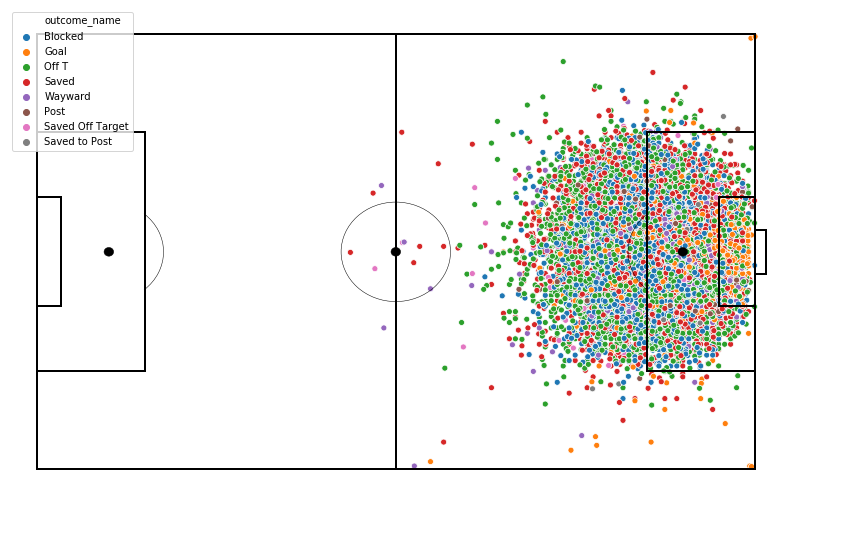

In [346]:
#plotting all shots
plt1 = pitch_creator()
plt1 = plotter_shots(plt)
plt.legend(loc='upper left')
plt.show()

In [384]:
def plotter(fig,loc_list,color,label):
    
    loc_x=[]
    loc_y=[]
    for loc in loc_list:
        loc_x.append(loc[0])
        loc_y.append(loc[1])
            
    plt.scatter(loc_x,loc_y,c=color,alpha='0.6',label=label,edgecolor='black',linewidth=0.5)
    plt.axis('off')
    
    
    return fig

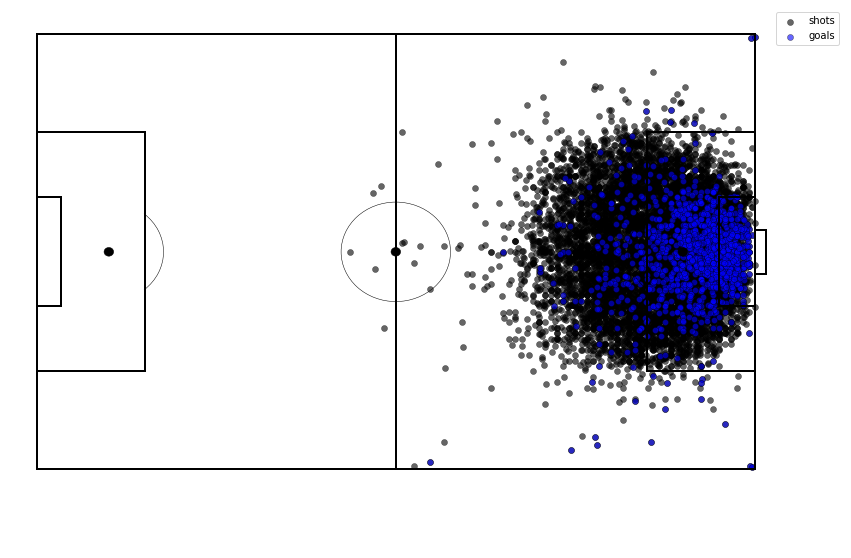

In [385]:
#plotting all data
plt1 = pitch_creator()
plt1 = plotter(plt,df[['shot_x','shot_y']].values,'black','shots')
plt1 = plotter(plt,df[df['outcome_name']=='Goal'][['shot_x','shot_y']].values,'blue','goals')
plt.legend(loc='upper right')
plt.show()